## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [36]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [37]:
from tqdm import tqdm

import seaborn as sns

sns.set(style='darkgrid')

In [38]:
# ''' Буду использовать MPS '''
# if torch.backends.mps.is_built():
#     print("PyTorch is built with MPS support")
# else:
#     print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     print ("MPS device not found.")

In [39]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [40]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [41]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [42]:
len(fmnist_dataset_test)

10000

In [43]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [44]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [45]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 512]                 401,920
|    └─BatchNorm1d: 2-3                  [-1, 512]                 1,024
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 256]                 131,328
|    └─BatchNorm1d: 2-6                  [-1, 256]                 512
|    └─ReLU: 2-7                         [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 10]                  2,570
|    └─LogSoftmax: 2-9                   [-1, 10]                  --
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
Total mult-adds (M): 1.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 512]                 401,920
|    └─BatchNorm1d: 2-3                  [-1, 512]                 1,024
|    └─ReLU: 2-4                         [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 256]                 131,328
|    └─BatchNorm1d: 2-6                  [-1, 256]                 512
|    └─ReLU: 2-7                         [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 10]                  2,570
|    └─LogSoftmax: 2-9                   [-1, 10]                  --
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0
Total mult-adds (M): 1.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 

Your experiments come here:

In [46]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters()) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE
n_epochs = 20
# Your experiments, training and validation loops here

In [47]:
model.train()

for epoch in range(n_epochs):
        
    for batch in tqdm(train_loader, position=0, leave=False):
        
        images, labels = batch
        
        outputs = model(images)
        loss = loss_func(outputs, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

In [48]:
model.eval()

predicted_labels_train = []
real_labels_train = []

with torch.no_grad():
    for batch in train_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels_train.append(y_predicted.argmax(dim=1))
        real_labels_train.append(batch[1])

predicted_labels_train = torch.cat(predicted_labels_train)
real_labels_train = torch.cat(real_labels_train)
train_acc = (predicted_labels_train == real_labels_train).type(torch.FloatTensor).mean()

In [49]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.97435


In [50]:
model.eval()

predicted_labels_test = []
real_labels_test = []

with torch.no_grad():
    for batch in test_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels_test.append(y_predicted.argmax(dim=1))
        real_labels_test.append(batch[1])

predicted_labels_test = torch.cat(predicted_labels_test)
real_labels_test = torch.cat(real_labels_test)
test_acc = (predicted_labels_test == real_labels_test).type(torch.FloatTensor).mean()

In [51]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.8943


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [64]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [65]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 1024]                803,840
|    └─ReLU: 2-3                         [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─ReLU: 2-5                         [-1, 512]                 --
|    └─Linear: 2-6                       [-1, 256]                 131,328
|    └─ReLU: 2-7                         [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 10]                  2,570
|    └─LogSoftmax: 2-9                   [-1, 10]                  --
Total params: 1,462,538
Trainable params: 1,462,538
Non-trainable params: 0
Total mult-adds (M): 2.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.58
Estimated Total Size (

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 1024]                803,840
|    └─ReLU: 2-3                         [-1, 1024]                --
|    └─Linear: 2-4                       [-1, 512]                 524,800
|    └─ReLU: 2-5                         [-1, 512]                 --
|    └─Linear: 2-6                       [-1, 256]                 131,328
|    └─ReLU: 2-7                         [-1, 256]                 --
|    └─Linear: 2-8                       [-1, 10]                  2,570
|    └─LogSoftmax: 2-9                   [-1, 10]                  --
Total params: 1,462,538
Trainable params: 1,462,538
Non-trainable params: 0
Total mult-adds (M): 2.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.58
Estimated Total Size (

In [66]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters()) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE
n_epochs = 40

# Your experiments, come here
train_losses_overfit = []
train_accuracies_overfit = []
test_losses_overfit = []
test_accuracies_overfit = []

In [67]:
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for batch in tqdm(train_loader, position=0, leave=False):
        
        images, labels = batch
        outputs = model(images)
        loss = loss_func(outputs, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_losses_overfit.append(avg_loss)

    accuracy_train = correct_train / total_train
    train_accuracies_overfit.append(accuracy_train)

    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses_overfit.append(avg_test_loss)

    accuracy_test = correct_test / total_test
    test_accuracies_overfit.append(accuracy_test)

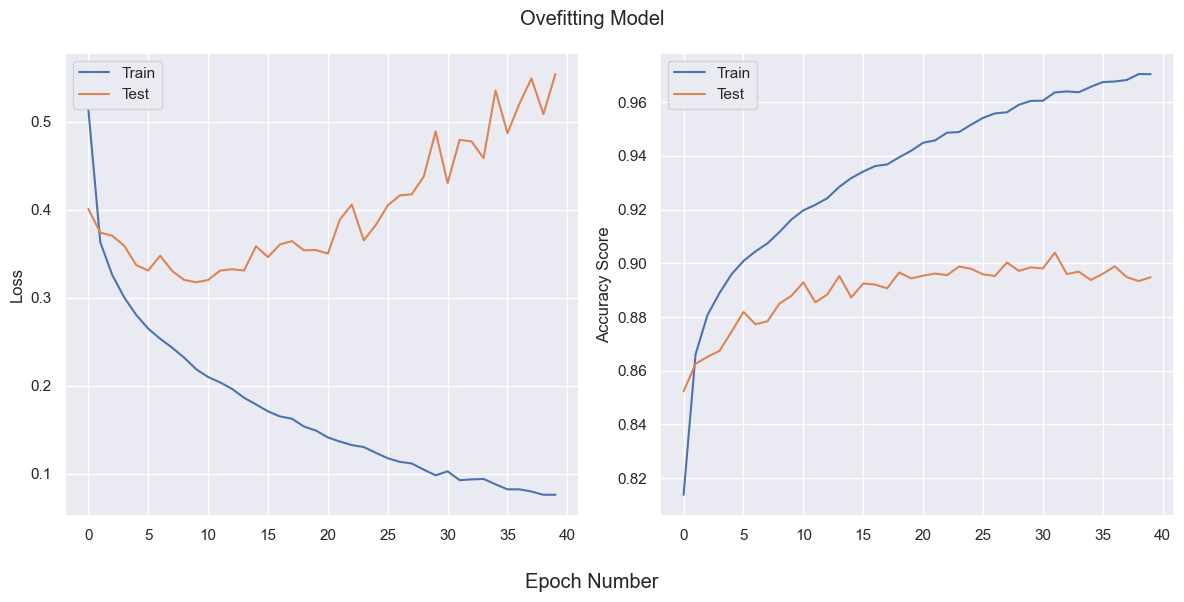

Final Loss on test set = 0.5540486058409442
Final Accuracy Score on test set = 0.8948


In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Ovefitting Model')
fig.supxlabel('Epoch Number')

plt.subplot(1, 2, 1)
plt.plot(train_losses_overfit, label='Train')
plt.plot(test_losses_overfit, label='Test')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_overfit, label='Train')
plt.plot(test_accuracies_overfit, label='Test')
plt.ylabel('Accuracy Score')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Final Loss on test set = {test_losses_overfit[-1]}')
print(f'Final Accuracy Score on test set = {test_accuracies_overfit[-1]}')

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [69]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [70]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 1024]                803,840
|    └─BatchNorm1d: 2-3                  [-1, 1024]                2,048
|    └─ReLU: 2-4                         [-1, 1024]                --
|    └─Dropout: 2-5                      [-1, 1024]                --
|    └─Linear: 2-6                       [-1, 512]                 524,800
|    └─BatchNorm1d: 2-7                  [-1, 512]                 1,024
|    └─ReLU: 2-8                         [-1, 512]                 --
|    └─Dropout: 2-9                      [-1, 512]                 --
|    └─Linear: 2-10                      [-1, 256]                 131,328
|    └─BatchNorm1d: 2-11                 [-1, 256]                 512
|    └─ReLU: 2-12                        [-1, 256]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 1024]                803,840
|    └─BatchNorm1d: 2-3                  [-1, 1024]                2,048
|    └─ReLU: 2-4                         [-1, 1024]                --
|    └─Dropout: 2-5                      [-1, 1024]                --
|    └─Linear: 2-6                       [-1, 512]                 524,800
|    └─BatchNorm1d: 2-7                  [-1, 512]                 1,024
|    └─ReLU: 2-8                         [-1, 512]                 --
|    └─Dropout: 2-9                      [-1, 512]                 --
|    └─Linear: 2-10                      [-1, 256]                 131,328
|    └─BatchNorm1d: 2-11                 [-1, 256]                 512
|    └─ReLU: 2-12                        [-1, 256]             

In [71]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())  # YOUR CODE HERE
loss_func = nn.NLLLoss()  # YOUR CODE HERE
n_epochs = 40

# Your experiments, come here
train_losses_fixed = []
train_accuracies_fixed = []
test_losses_fixed = []
test_accuracies_fixed = []

In [72]:
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for batch in tqdm(train_loader, position=0, leave=False):
        
        images, labels = batch
        outputs = model(images)
        loss = loss_func(outputs, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    train_losses_fixed.append(avg_loss)

    accuracy_train = correct_train / total_train
    train_accuracies_fixed.append(accuracy_train)

    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses_fixed.append(avg_test_loss)

    accuracy_test = correct_test / total_test
    test_accuracies_fixed.append(accuracy_test)

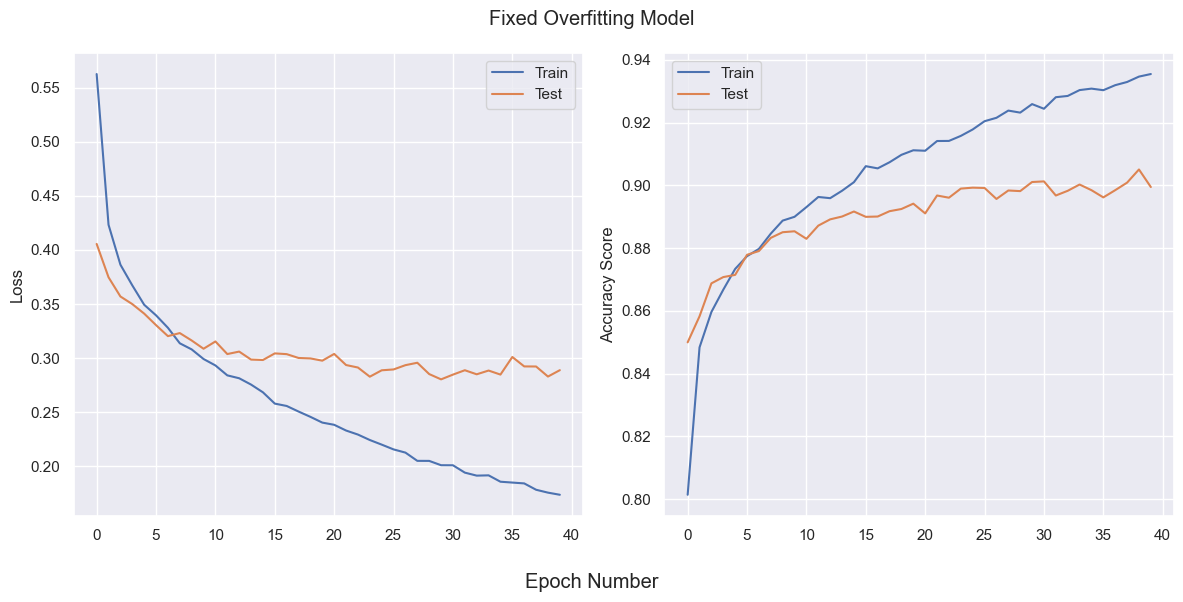

Final Loss on test set = 0.2888218201929703
Final Accuracy Score on test set = 0.8995


In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('Fixed Overfitting Model')
fig.supxlabel('Epoch Number')

plt.subplot(1, 2, 1)
plt.plot(train_losses_fixed, label='Train')
plt.plot(test_losses_fixed, label='Test')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_fixed, label='Train')
plt.plot(test_accuracies_fixed, label='Test')
plt.ylabel('Accuracy Score')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Final Loss on test set = {test_losses_fixed[-1]}')
print(f'Final Accuracy Score on test set = {test_accuracies_fixed[-1]}')

### Conclusions:
_Write down small report with your conclusions and your ideas._

Из проделанной работы видно, что у более сложной модели получилось лишь немного повысить точность исходной (скорее всего, что из-за работы dropout падает точность). С переобученной моделью у конечной версии разница в accuracy вообще минимальна, но явно видно, что стала гораздо лучше ситуация с loss. Предполагаю, что явное преимущество в работе модели избегающее переобуения видно будет при больших размерах датасетов.